This notebook is created for the evaluation metric number 2. b
Feature importance consistency and evaluation

Feature Importance Consistency evaluation ensures that the most influential features in the real dataset remain similarly important in the synthetic dataset. This helps validate whether the synthetic data maintains the same predictive relationships as the original data.

**Data Sanity checks**
In the below cells, I am loading the 10k rows of the real dataset and the synthetically generated dataset (with and without DP) and checking if all the formatting and correct dataset is loaded properly.

In [9]:
import pandas as pd
import numpy as np
import json
import re

In [2]:
def load_jsonl(file_path, max_rows=None):
    data = []
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)



In [10]:
# Replace these with your actual uploaded filenames
file1 = "train.jsonl"  # Limited to 10K rows
file2 = "generated_sequences_no_dp.jsonl"  # No limit
file3 = "generated_sequences_with_dp.jsonl"  # No limit

# Load JSONL files into separate DataFrames
real_data = load_jsonl(file1, max_rows=10000)  # Load only 10K rows
synthetic_no_dp = load_jsonl(file2)  # Load full file
synthetic_dp = load_jsonl(file3)  # Load full file

In [6]:
real_data.head(3)

,System prompt,Rating,Review Title,Review,Product Title,Product Categories
0,"Given the Rating and Title, you are required t...",4,No white background! It’s clear!,I bought this bc I thought it had the nice whi...,VUIIMEEK Square Case for iPhone 12 Pro Max 6.7...,Cell Phones & Accessories
1,"Given the Rating and Title, you are required t...",5,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,"Fitian Fitbit Ionic Charging Cable, Replacemen...",All Electronics
2,"Given the Rating and Title, you are required t...",5,Worked but took an hour to install,Overall very happy with the end result. If you...,Keytas Compatible with iPhone XR Screen Replac...,Cell Phones & Accessories


In [7]:
real_data = real_data[["Rating", "Review Title", "Review"]]

In [8]:
real_data.head(3)

,Rating,Review Title,Review
0,4,No white background! It’s clear!,I bought this bc I thought it had the nice whi...
1,5,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...
2,5,Worked but took an hour to install,Overall very happy with the end result. If you...


In [11]:
sythetic_no_dp.head(3)

,generated_text
0,"""System prompt : Given the Rating and Title, y..."
1,"""System prompt : Given the Rating and Title, y..."
2,"""System prompt : Given the Rating and Title, y..."


In [13]:
def extract_synthetic_data(text):
    rating_match = re.search(r'"Rating":\s*(\d+)', text)
    title_match = re.search(r'"Title":\s*([^|]+)', text)
    review_match = re.search(r'"Review":\s*(.*)', text)

    rating = int(rating_match.group(1)) if rating_match else None
    title = title_match.group(1).strip() if title_match else None
    review = review_match.group(1).strip() if review_match else None

    return rating, title, review


In [19]:
# Apply extraction function to each row
synthetic_no_dp_data = synthetic_no_dp["generated_text"].apply(lambda x: extract_synthetic_data(x))

# Convert extracted data into a DataFrame with proper column names
df_synthetic_no_dp = pd.DataFrame(synthetic_no_dp_data.tolist(), columns=["Rating", "Review Title", "Review"])

In [20]:
df_synthetic_no_dp.head(3)

,Rating,Review Title,Review
0,4,No white background! It’s clear!,Angeles and the white background is clear. I t...
1,5,Awesome! Great price! Works well!,://i.imgur.com/tj5p1Xq<br /><br />Works great ...
2,5,Worked but took an hour to install,://en.wikipedia.org/2019/2/21/How_to_install_s...


In [21]:
synthetic_dp.head(3)

,generated_text
0,"""System prompt : Given the Rating and Title, y..."
1,"""System prompt : Given the Rating and Title, y..."
2,"""System prompt : Given the Rating and Title, y..."


In [22]:
synthetic_dp_data = synthetic_dp["generated_text"].apply(lambda x: extract_synthetic_data(x))

# Convert extracted data into a DataFrame with proper column names
df_synthetic_dp = pd.DataFrame(synthetic_dp_data.tolist(), columns=["Rating", "Review Title", "Review"])

In [23]:
df_synthetic_dp.head(3)

,Rating,Review Title,Review
0,4,No white background! It’s clear!,:// The screen protector is clear and does not...
1,5,Awesome! Great price! Works well!,://5 stars//Great product. Great price. Work...
2,5,Worked but took an hour to install,:// The screen protector did not stick to the ...


These are the final dataframes being used:
1. real_data
2. df_synthetic_no_dp
3. df_synthetic_dp


Clean up: Removing unwanted special chars and decoding.

In [27]:
def clean_review(text):
    text = re.sub(r"^://", "", text).strip()  # Remove leading '://'
    try:
        text = text.encode('utf-8').decode('unicode_escape')  # Safe Unicode decoding
    except UnicodeDecodeError:
        text = text.encode('utf-8', 'ignore').decode('asutf-8')  # Ignore errors
    return text

# Apply cleaning function to the Review column
df_synthetic_dp["Review"] = df_synthetic_dp["Review"].apply(clean_review)
df_synthetic_no_dp["Review"] = df_synthetic_no_dp["Review"].apply(clean_review)

<ipython-input-27-5827f0d7f8af>:4: DeprecationWarning: invalid escape sequence '\/'
  text = text.encode('utf-8').decode('unicode_escape')  # Safe Unicode decoding


**Feature Importance**

"Review Title" and "Review" are text data, which require text embeddings before feature importance can be extracted.   
"Rating" is numeric and the target variable.
🔹 Best Approach: Using NLP-Based Feature Importance
We'll use:

TF-IDF Vectorization: To transform text columns (Review Title & Review) into numerical features.
Logistic Regression with Permutation Importance: To determine which text features influence Rating the most.
SHAP (SHapley Additive Explanations): To analyze word-level importance.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def compute_text_feature_importance(df):
    df = df.dropna()  # Remove any missing values
    X = df[["Review Title", "Review"]].astype(str).apply(lambda x: x.str.lower())  # Convert text to lowercase
    y = df["Rating"]  # Target variable

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(stop_words="english", max_features=500)  # Limit features to prevent overfitting
    X_tfidf = tfidf.fit_transform(X["Review Title"] + " " + X["Review"])  # Combine text columns

    # Convert sparse matrix to dense array
    X_tfidf = X_tfidf.toarray()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    # Train Logistic Regression Model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Compute Permutation Importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importances = pd.DataFrame({
        "Feature": tfidf.get_feature_names_out(),
        "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

    return feature_importances

In [32]:
importance_results = {}
for name, df in datasets.items():
    importance_results[name] = compute_text_feature_importance(df)

# Compare Feature Importance Across Datasets
comparison_df = importance_results["Real Data"].merge(
    importance_results["Synthetic No DP"], on="Feature", suffixes=("_Real", "_No_DP")
).merge(
    importance_results["Synthetic DP"], on="Feature", suffixes=("", "_DP")
)

# Rename columns for clarity
comparison_df.rename(columns={"Importance": "Importance_DP"}, inplace=True)

In [33]:
comparison_df

,Feature,Importance_Real,Importance_No_DP,Importance_DP
0,great,0.01035,3.200000e-03,1.055000e-02
1,love,0.00685,4.500000e-03,5.750000e-03
2,ok,0.00615,2.250000e-03,4.100000e-03
3,nice,0.00430,8.500000e-04,-4.500000e-04
4,good,0.00430,4.000000e-04,-9.500000e-04
...,...,...,...,...
330,chargers,-0.00095,-1.110223e-17,-1.110223e-17
331,got,-0.00095,5.000000e-05,2.500000e-04
332,material,-0.00100,4.000000e-04,-1.000000e-04
333,light,-0.00110,7.000000e-04,2.500000e-04


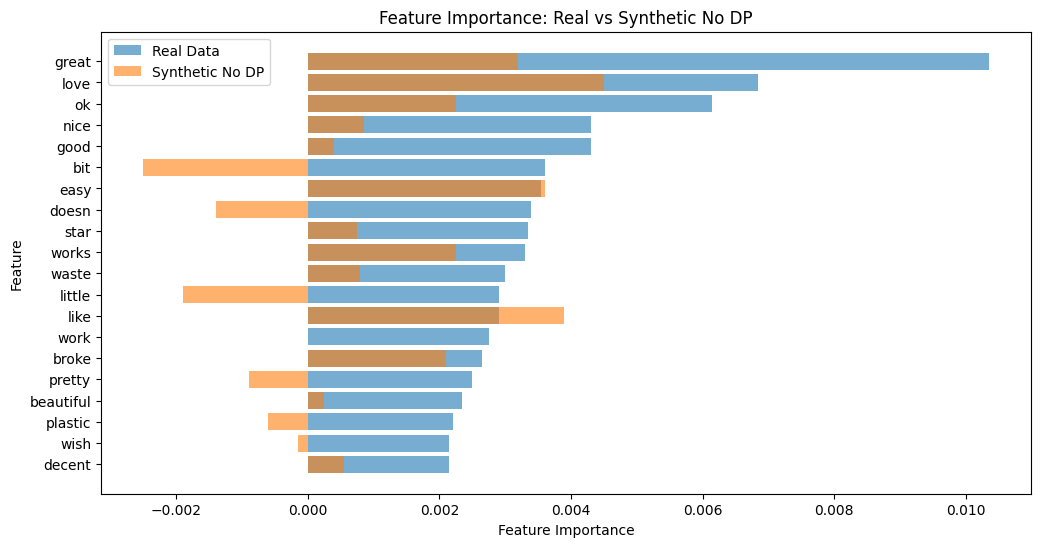

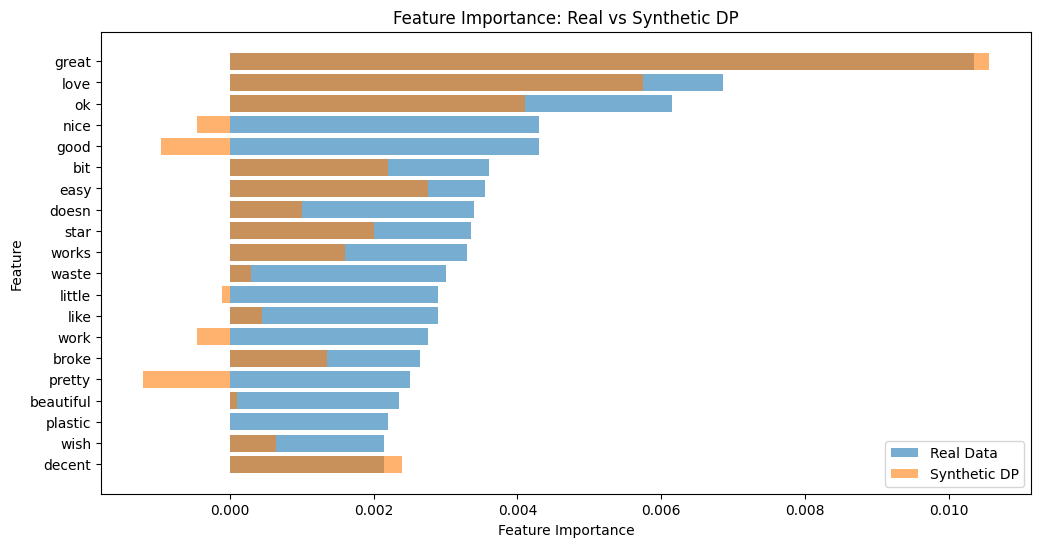

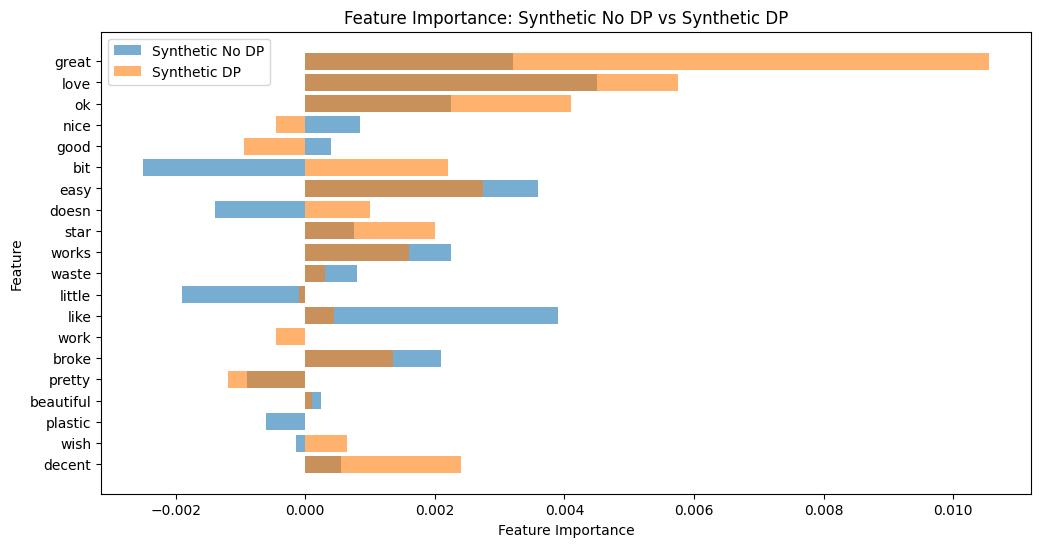

In [35]:
def plot_feature_importance_comparison(comparison_df):
    top_features = 20  # Limit to top 20 features for readability

    # Sort by real data importance
    sorted_df = comparison_df.sort_values(by="Importance_Real", ascending=False).head(top_features)

    # Plot Real vs Synthetic No DP
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_df["Feature"], sorted_df["Importance_Real"], label="Real Data", alpha=0.6)
    plt.barh(sorted_df["Feature"], sorted_df["Importance_No_DP"], label="Synthetic No DP", alpha=0.6)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance: Real vs Synthetic No DP")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

    # Plot Real vs Synthetic DP
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_df["Feature"], sorted_df["Importance_Real"], label="Real Data", alpha=0.6)
    plt.barh(sorted_df["Feature"], sorted_df["Importance_DP"], label="Synthetic DP", alpha=0.6)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance: Real vs Synthetic DP")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

    # Plot Synthetic No DP vs Synthetic DP
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_df["Feature"], sorted_df["Importance_No_DP"], label="Synthetic No DP", alpha=0.6)
    plt.barh(sorted_df["Feature"], sorted_df["Importance_DP"], label="Synthetic DP", alpha=0.6)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance: Synthetic No DP vs Synthetic DP")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

# Generate the plots
plot_feature_importance_comparison(comparison_df)

**Feature Importance Correlation Matrix (Heatmap)**  
Helps identify patterns in how synthetic data affects word importance.

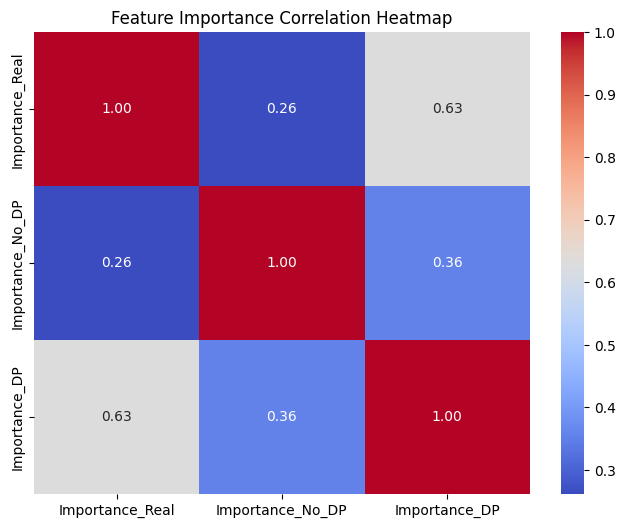

In [37]:
# Create a correlation matrix for feature importances
importance_corr = comparison_df[["Importance_Real", "Importance_No_DP", "Importance_DP"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(importance_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Importance Correlation Heatmap")
plt.show()

Inference : If correlation is high (near 1), synthetic data preserves feature importance well.
If correlation is low (near 0), the synthetic dataset distorts relationships

**Jaccard Similarity of Top-K Features**  
Instead of looking at the importance values, we can compare the top-K features.
This metric helps evaluate whether synthetic datasets retain the most influential words.

In [38]:
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

top_k = 20  # Number of top features to compare

# Get top K features for each dataset
top_real = set(comparison_df.nlargest(top_k, "Importance_Real")["Feature"])
top_no_dp = set(comparison_df.nlargest(top_k, "Importance_No_DP")["Feature"])
top_dp = set(comparison_df.nlargest(top_k, "Importance_DP")["Feature"])

# Compute Jaccard Similarities
jaccard_real_no_dp = jaccard_similarity(top_real, top_no_dp)
jaccard_real_dp = jaccard_similarity(top_real, top_dp)
jaccard_no_dp_dp = jaccard_similarity(top_no_dp, top_dp)

# Display results
jaccard_results = pd.DataFrame({
    "Comparison": ["Real vs No DP", "Real vs DP", "No DP vs DP"],
    "Jaccard Similarity": [jaccard_real_no_dp, jaccard_real_dp, jaccard_no_dp_dp]
})

In [39]:
jaccard_results

,Comparison,Jaccard Similarity
0,Real vs No DP,0.212121
1,Real vs DP,0.290323
2,No DP vs DP,0.290323


Inference: A higher Jaccard similarity (closer to 1) means the synthetic dataset preserves key predictive words.
A lower Jaccard similarity means word importance differs significantly across datasets.

**Scatter Plot: Real vs Synthetic Feature Importances**  
Instead of bar charts, use scatter plots to visually assess alignment between real and synthetic feature importances.

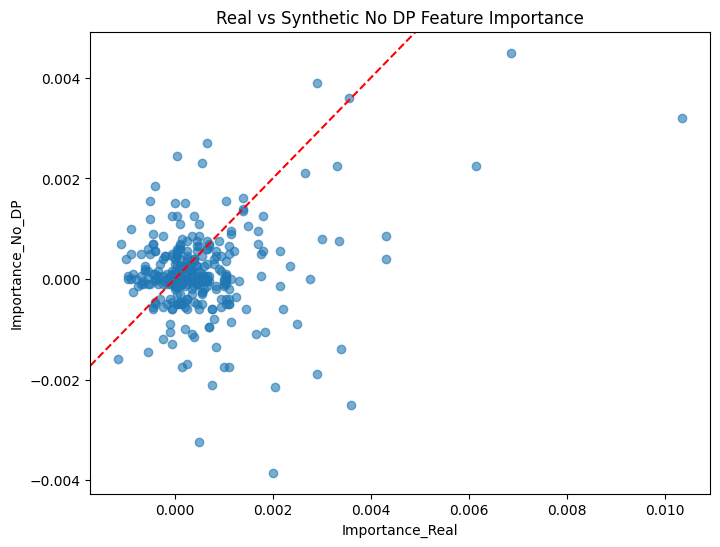

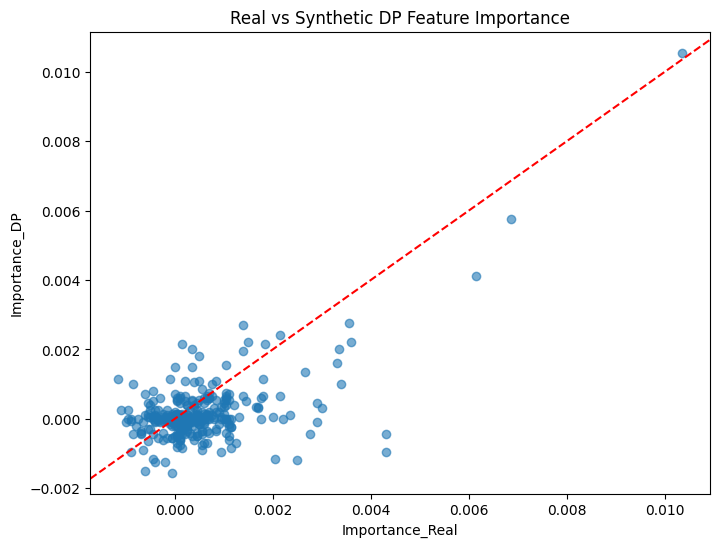

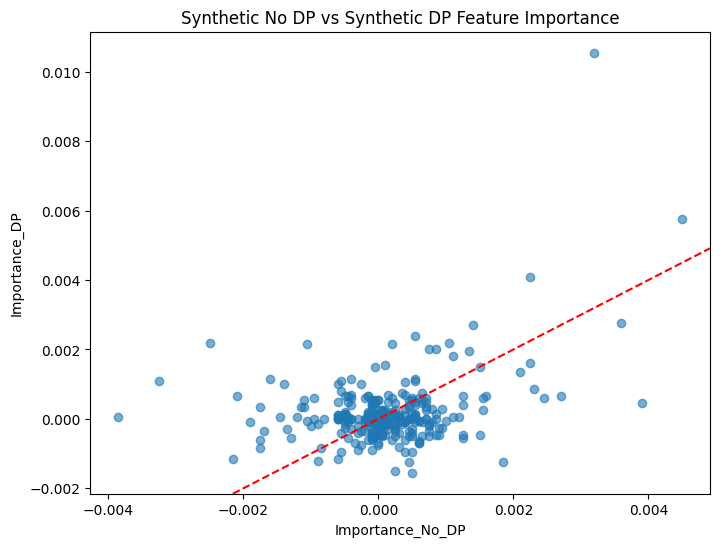

In [40]:
def plot_scatter_importance(comparison_df, x_col, y_col, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(comparison_df[x_col], comparison_df[y_col], alpha=0.6)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.axline((0, 0), slope=1, color='red', linestyle="dashed")  # Perfect correlation line
    plt.show()

# Scatter plots for comparison
plot_scatter_importance(comparison_df, "Importance_Real", "Importance_No_DP", "Real vs Synthetic No DP Feature Importance")
plot_scatter_importance(comparison_df, "Importance_Real", "Importance_DP", "Real vs Synthetic DP Feature Importance")
plot_scatter_importance(comparison_df, "Importance_No_DP", "Importance_DP", "Synthetic No DP vs Synthetic DP Feature Importance")

Inference: If points align along the red diagonal, synthetic data closely follows real data.
Deviations from the line indicate changes in feature importance.